Random undirected graph created with 100 nodes and 500 edges.
Calculating closeness centrality using NetworkX...

Top 10 nodes by closeness centrality (NetworkX):
1. Node: 0, Closeness Centrality: 0.5156250000
2. Node: 16, Closeness Centrality: 0.5076923077
3. Node: 67, Closeness Centrality: 0.5025380711
4. Node: 21, Closeness Centrality: 0.4974874372
5. Node: 99, Closeness Centrality: 0.4974874372
6. Node: 56, Closeness Centrality: 0.4925373134
7. Node: 72, Closeness Centrality: 0.4925373134
8. Node: 73, Closeness Centrality: 0.4925373134
9. Node: 4, Closeness Centrality: 0.4900990099
10. Node: 28, Closeness Centrality: 0.4900990099

Total time taken for NetworkX calculation: 0.0024 seconds
Processing graph with 100 nodes and 500 edges.
Calculating initial lower bounds...
1. Node: 0, Refined Closeness Centrality paper: 0.5156250000
2. Node: 16, Refined Closeness Centrality paper: 0.5076923077
3. Node: 67, Refined Closeness Centrality paper: 0.5025380711
4. Node: 99, Refined Closeness 

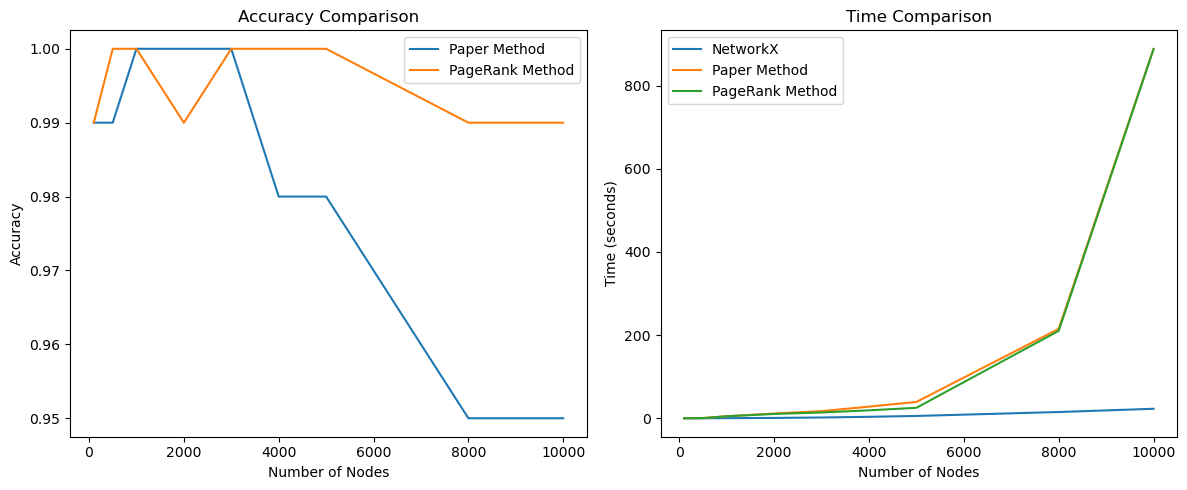

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import heapq
import csv
import re
import time
import cProfile
from collections import defaultdict
import networkx as nx
import itertools
import pandas as pd

def neighborhood_lower_bound(graph):
    nodes = list(graph.nodes())
    n = len(nodes)
    lower_bounds = {}

    k = 2
    max_iterations = 100000  # Set maximum iterations

    Y = {}
    S_un = {}
    nVisited = {}
    finished = {}

    for s in nodes:
        degree_s = graph.degree(s)
        Y[(1, s)] = degree_s
        S_un[s] = degree_s
        nVisited[s] = degree_s + 1
        finished[s] = False

    nFinished = 0

    while nFinished < n and k <= max_iterations:
        for s in nodes:
            if finished[s]:
                continue
            if k == 2:
                Y[(k, s)] = sum(Y.get((k-1, w), 0) for w in graph.neighbors(s)) - graph.degree(s)
            else:
                Y[(k, s)] = sum(Y.get((k-1, w), 0) for w in graph.neighbors(s)) - Y.get((k-2, s), 0) * (graph.degree(s) - 1)
        
        for s in nodes:
            if finished[s]:
                continue
            y_k_minus_2 = Y.get((k-2, s), 0)
            y_k_minus_1 = Y.get((k-1, s), 0)
            nVisited[s] += y_k_minus_1
            
            if nVisited[s] < n:
                S_un[s] += k * y_k_minus_1
            else:
                S_un[s] += k *(n - (nVisited[s] - y_k_minus_1))
                nFinished += 1
                finished[s] = True
            Y[(k-2, s)] = y_k_minus_1
            Y[(k-1, s)] = Y[(k, s)]
        
        k += 1

    for v in nodes:
        lower_bounds[v] = S_un[v] / (n - 1)

    return lower_bounds

def updateBoundsBFSCut(v, graph, x):
    """
    Calculate the lower bound of the cut size that separates vertex v.

    Parameters:
        v: Starting vertex.
        graph: networkx DiGraph. Nodes must have 'r' attribute.
        Farn: Dictionary that stores the lower bounds (must be initialized).
        Top: List of top k nodes (must be initialized).
        x: A threshold.

    Returns:
        If the cut value exceeds x, return +∞; otherwise, return the calculated cut value or the current Farn[v] if unchanged.
    """
    
    nodes = list(graph.nodes())
    n = len(nodes)
    Q = [(0, v)]  # Priority queue to track BFS (distance, node)
    heapq.heapify(Q)
    visited = {v}
    d = 0
    S = 0
    y = graph.degree(v) - 1
    nd = 1

    while Q:
        dist, u = heapq.heappop(Q)
        if dist > d:
            d += 1
            # LCUT calculation
            LCUT = ((d + 2) * (n - nd) + S - y) / (n - 1)

            if LCUT >= x:
                return float('inf')
            y = 0  # Reset y

        for w in graph.neighbors(u):
            if w not in visited:
                visited.add(w)
                dist_vw = nx.shortest_path_length(graph, v, w)  # Assume a shortest path exists
                heapq.heappush(Q, (dist_vw, w))
                S += dist_vw  # Distance d(v, w)
                y += graph.degree(w)
                nd += 1
            else:
                LCUT += 1 / (n - 1)

    # Final calculation
    LCUT_final = S / (n - 1)

    return LCUT_final

def pagerank_lower_bound(graph):
    # Calculate PageRank for each node
    page_ranks = nx.pagerank(graph)
    
    # Use the reciprocal of PageRank as a lower bound
    lower_bounds = {node: 1 / page_ranks[node] for node in graph.nodes()}
    
    return lower_bounds

def calculate_top_k_closeness_centrality_nx(graph, top_k=10):
    start_time = time.time()
    
    print("Calculating closeness centrality using NetworkX...")
    closeness_centrality = nx.closeness_centrality(graph)
    
    top_k_nodes = heapq.nlargest(top_k, closeness_centrality.items(), key=lambda x: x[1])
    
    print(f"\nTop {top_k} nodes by closeness centrality (NetworkX):")
    for i, (node, centrality) in enumerate(top_k_nodes, 1):
        print(f"{i}. Node: {node}, Closeness Centrality: {centrality:.10f}")
    
    end_time = time.time()
    total_time = end_time - start_time
    print(f"\nTotal time taken for NetworkX calculation: {total_time:.4f} seconds")
    
    return [node for node, _ in top_k_nodes]

def create_random_undirected_graph(num_nodes=1000, num_edges=5000):
    graph = nx.gnm_random_graph(num_nodes, num_edges)
    print(f"Random undirected graph created with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")
    return graph

def calculate_top_k_closeness_centrality_paper(graph, top_k=10):
    start_time = time.time()

    print(f"Processing graph with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")
    print("Calculating initial lower bounds...")

    initial_lower_bounds = neighborhood_lower_bound(graph)
    k_lowest_farness = heapq.nsmallest(top_k, initial_lower_bounds.items(), key=lambda item: item[1])
    #print(f"\n{top_k} nodes with lowest farness values:")
    #for node, farness in k_lowest_farness:
        #print(f"Node: {node}, Farness: {farness}")
    
    Farn = initial_lower_bounds.copy()
    Top = []
    Q = [(Farn[node], node) for node in graph.nodes()]
    heapq.heapify(Q)

    initial_threshold = float('inf')

    _, v = heapq.heappop(Q)
    
    #print(f"Processing node {v}")

    threshold = initial_threshold if len(Top) < top_k else Farn[Top[-1]]
    refined_bound = updateBoundsBFSCut(v, graph, threshold)
    
    #print(f"Refined bound for node {v}: {refined_bound}")

    Farn[v] = refined_bound

    while Q:
        if len(Top) < top_k:
            Top.append(v)
            Top.sort(key=lambda node: Farn[node])
            #print(f"Added node {v} to Top. Current Top: {Top}")
        elif refined_bound < Farn[Top[-1]]:
            Top.append(v)
            Top.sort(key=lambda node: Farn[node])
            Top = Top[:top_k]  # Maintain Top's length to top_k
            #print(f"Added node {v} to Top and trimmed. Current Top: {Top}")
        #else:
            #print(f"Node {v} not added to Top as its bound is not better than current top")

        _, v = heapq.heappop(Q)
    
        #print(f"Processing node {v}")

        threshold = initial_threshold if len(Top) < top_k else Farn[Top[-1]]
        refined_bound = updateBoundsBFSCut(v, graph, threshold)
    
        #print(f"Refined bound for node {v}: {refined_bound}")

        Farn[v] = refined_bound
        
        #if len(Top) == top_k and Farn[v] >= Farn[Top[-1]]:
            #print(Farn[Q[0][1]])
            #print(Farn[Top[-1]])
            #print("Remaining nodes in Q cannot improve Top. Stopping.")
            #break

    #print("\nFinal Top 10 nodes by refined closeness centrality:")
    for i, node in enumerate(Top, 1):
        closeness = 1 / Farn[node] if Farn[node] != 0 else float('inf')
        print(f"{i}. Node: {node}, Refined Closeness Centrality paper: {closeness:.10f}")

    end_time = time.time()
    total_time = end_time - start_time
    print(f"\nTotal time taken: {total_time:.4f} seconds")

    return Top

def calculate_top_k_closeness_centrality_pagerank(graph, top_k=10):
    start_time = time.time()

    print(f"Processing graph with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")
    print("Calculating initial lower bounds...")

    initial_lower_bounds = pagerank_lower_bound(graph)
    k_lowest_farness = heapq.nsmallest(top_k, initial_lower_bounds.items(), key=lambda item: item[1])
    #print(f"\n{top_k} nodes with lowest farness values:")
    #for node, farness in k_lowest_farness:
        #print(f"Node: {node}, Farness: {farness}")
    
    Farn = initial_lower_bounds.copy()
    Top = []
    Q = [(Farn[node], node) for node in graph.nodes()]
    heapq.heapify(Q)

    initial_threshold = float('inf')

    _, v = heapq.heappop(Q)
    
    #print(f"Processing node {v}")

    threshold = initial_threshold if len(Top) < top_k else Farn[Top[-1]]
    refined_bound = updateBoundsBFSCut(v, graph, threshold)
    
    #print(f"Refined bound for node {v}: {refined_bound}")

    Farn[v] = refined_bound

    while Q:
        if len(Top) < top_k:
            Top.append(v)
            Top.sort(key=lambda node: Farn[node])
            #print(f"Added node {v} to Top. Current Top: {Top}")
        elif refined_bound < Farn[Top[-1]]:
            Top.append(v)
            Top.sort(key=lambda node: Farn[node])
            Top = Top[:top_k]  # Maintain Top's length to top_k
            #print(f"Added node {v} to Top and trimmed. Current Top: {Top}")
        #else:
           # print(f"Node {v} not added to Top as its bound is not better than current top")

        _, v = heapq.heappop(Q)
    
        #print(f"Processing node {v}")

        threshold = initial_threshold if len(Top) < top_k else Farn[Top[-1]]
        refined_bound = updateBoundsBFSCut(v, graph, threshold)
    
        #print(f"Refined bound for node {v}: {refined_bound}")

        Farn[v] = refined_bound
        
        #if len(Top) == top_k and Farn[v] >= Farn[Top[-1]]:
            #print(Farn[Q[0][1]])
            #print(Farn[Top[-1]])
            #print("Remaining nodes in Q cannot improve Top. Stopping.")
            #break

    print("\nFinal Top 10 nodes by refined closeness centrality:")
    for i, node in enumerate(Top, 1):
        closeness = 1 / Farn[node] if Farn[node] != 0 else float('inf')
        print(f"{i}. Node: {node}, Refined Closeness Centrality pagerank: {closeness:.10f}")

    end_time = time.time()
    total_time = end_time - start_time
    print(f"\nTotal time taken: {total_time:.4f} seconds")

    return Top
    
def evaluate_methods(num_nodes_list, num_edges_multiplier=5, top_k=10, num_trials=10):
    accuracy_paper = []
    accuracy_pagerank = []
    time_nx = []
    time_paper = []
    time_pagerank = []

    for num_nodes in num_nodes_list:
        num_edges = num_nodes * num_edges_multiplier
        acc_paper_trials = []
        acc_pagerank_trials = []
        time_nx_trials = []
        time_paper_trials = []
        time_pagerank_trials = []

        for _ in range(num_trials):
            graph = create_random_undirected_graph(num_nodes=num_nodes, num_edges=num_edges)

            start_time = time.time()
            nx_top_k_nodes = calculate_top_k_closeness_centrality_nx(graph, top_k=top_k)
            time_nx_trials.append(time.time() - start_time)

            start_time = time.time()
            paper_top_k_nodes = calculate_top_k_closeness_centrality_paper(graph, top_k=top_k)
            time_paper_trials.append(time.time() - start_time)

            start_time = time.time()
            pagerank_top_k_nodes = calculate_top_k_closeness_centrality_pagerank(graph, top_k=top_k)
            time_pagerank_trials.append(time.time() - start_time)

            acc_paper_trials.append(len(set(paper_top_k_nodes) & set(nx_top_k_nodes)) / top_k)
            acc_pagerank_trials.append(len(set(pagerank_top_k_nodes) & set(nx_top_k_nodes)) / top_k)
            
            common_nodes_nx_paper = set(paper_top_k_nodes) & set(nx_top_k_nodes)
            print(f"\nNumber of common nodes in paper and nx methods: {len(common_nodes_nx_paper)}")
            print(f"Common nodes: {common_nodes_nx_paper}")
    
            common_nodes_nx_pagerank = set(pagerank_top_k_nodes) & set(nx_top_k_nodes)
            print(f"\nNumber of common nodes in pagerank and nx methods: {len(common_nodes_nx_pagerank)}")
            print(f"Common nodes: {common_nodes_nx_pagerank}")

        accuracy_paper.append(np.mean(acc_paper_trials))
        accuracy_pagerank.append(np.mean(acc_pagerank_trials))
        time_nx.append(np.mean(time_nx_trials))
        time_paper.append(np.mean(time_paper_trials))
        time_pagerank.append(np.mean(time_pagerank_trials))

        print(f"Completed evaluation for graph with {num_nodes} nodes and {num_edges} edges")

    return accuracy_paper, accuracy_pagerank, time_nx, time_paper, time_pagerank

def plot_results(num_nodes_list, accuracy_paper, accuracy_pagerank, time_nx, time_paper, time_pagerank):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(num_nodes_list, accuracy_paper, label='Paper Method')
    plt.plot(num_nodes_list, accuracy_pagerank, label='PageRank Method')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(num_nodes_list, time_nx, label='NetworkX')
    plt.plot(num_nodes_list, time_paper, label='Paper Method')
    plt.plot(num_nodes_list, time_pagerank, label='PageRank Method')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Time (seconds)')
    plt.title('Time Comparison')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    num_nodes_list = [100, 500, 1000, 2000, 3000, 4000, 5000, 8000, 10000]
    accuracy_paper, accuracy_pagerank, time_nx, time_paper, time_pagerank = evaluate_methods(num_nodes_list)
    plot_results(num_nodes_list, accuracy_paper, accuracy_pagerank, time_nx, time_paper, time_pagerank)